## A Network Analysis On The Subreddit r/mentalhealth:
**Who leads the conversation on mental health?**

In [ ]:
!pip install praw
!pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 3.9 MB/s eta 0:00:00


In [ ]:
import networkx as nx
import praw
import networkx as nx
from google.colab import userdata
import pandas as pd
import time
import warnings
import re
import logging
from sentence_transformers import SentenceTransformer

logging.getLogger("praw").setLevel(logging.ERROR)
logging.getLogger("prawcore").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [ ]:
reddit = (
    userdata.get('client_id'),
    userdata.get('client_secret'),
    userdata.get('user_agent')
)


In [ ]:
SUBREDDIT_NAME = "mentalhealth"
TARGET_COMMENTS = 5000
TARGET_USERS = 5000
TOP_POSTS_LIMIT = 50
NEW_POSTS_LIMIT = 50

g = nx.DiGraph()
unique_users = set()
total_comments = 0
comment_data = []

# Unpack your credentials
client_id, client_secret, user_agent = reddit

# Initialize Reddit instance
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent
)

subreddit = reddit.subreddit(SUBREDDIT_NAME)

def process_submission(submission):
    global total_comments

    submission.comments.replace_more(limit=0)
    comment_lookup = {}

    # Map post author
    if submission.author:
        comment_lookup[submission.id] = str(submission.author)
        unique_users.add(str(submission.author))
        g.add_node(str(submission.author))

    for comment in submission.comments.list():
        if comment.author is None or comment.body is None:
            continue

        author = str(comment.author)
        comment_id = comment.id
        parent_id = comment.parent_id.split("_")[1]

        comment_lookup[comment_id] = author
        unique_users.add(author)
        g.add_node(author)

        parent_author = comment_lookup.get(parent_id)
        if parent_author and parent_author != author:
            if g.has_edge(author, parent_author):
                g[author][parent_author]['weight'] += 1
            else:
                g.add_edge(author, parent_author, weight=1)

        # Store comment
        comment_data.append({"user": author, "comment": comment.body})
        total_comments += 1

        # Stop if targets met
        if total_comments >= TARGET_COMMENTS or len(unique_users) >= TARGET_USERS:
            return True

    return False

# Collect comments from top posts
for submission in subreddit.top(limit=TOP_POSTS_LIMIT):
    if process_submission(submission):
        break

# If still below targets, collect from new posts
if total_comments < TARGET_COMMENTS and len(unique_users) < TARGET_USERS:
    for submission in subreddit.new(limit=NEW_POSTS_LIMIT):
        if process_submission(submission):
            break

# Create DataFrame once
df = pd.DataFrame(comment_data)

print("\n=== Collection Complete ===")
print(f"Total comments collected: {len(df)}")
print(f"Unique users collected: {len(unique_users)}")
print(f"Total nodes in graph: {len(g.nodes)}")
print(f"Total edges in graph: {len(g.edges)}")

# Save graph and DataFrame
nx.write_graphml(g, "reddit_mentalhealth_combined.graphml")
df.to_csv("reddit_mentalhealth_comments.csv", index=False)
print("Graph and comments DataFrame saved.")



=== Collection Complete ===
Total comments collected: 5000
Unique users collected: 3712
Total nodes in graph: 3712
Total edges in graph: 3995
Graph and comments DataFrame saved.


**Measuring Influence Based on Degree Centrality, PageRank, and Betweenness Centrality**

In [ ]:
top_k = 10
centrality_degree = nx.degree_centrality(g)

print("\nTop 10 users by degree centrality:")
for user in sorted(centrality_degree, key=centrality_degree.get, reverse=True)[:top_k]:
    # No 'name' attribute assumed, so print username directly
    print(f"{user}: Degree Centrality = {centrality_degree[user]:.4f}")


Top 10 users by degree centrality:
Antiviral21: Degree Centrality = 0.0860
thefanaway: Degree Centrality = 0.0523
StarZealousideal2312: Degree Centrality = 0.0515
GuiltyWife2025: Degree Centrality = 0.0482
runawaylovebug: Degree Centrality = 0.0342
Quick_Ad_798: Degree Centrality = 0.0337
aristotlesbitch4561: Degree Centrality = 0.0334
Lemonad3_: Degree Centrality = 0.0331
WarmlyEccentric: Degree Centrality = 0.0323
Emmengard: Degree Centrality = 0.0318


In [ ]:
pagerank = nx.pagerank(g, weight='weight')
print("\nTop 10 users by PageRank:")
for user in sorted(pagerank, key=pagerank.get, reverse=True)[:top_k]:
    print(f"{user}: PageRank = {pagerank[user]:.4f}")


Top 10 users by PageRank:
Antiviral21: PageRank = 0.0609
GuiltyWife2025: PageRank = 0.0279
aristotlesbitch4561: PageRank = 0.0216
Lemonad3_: PageRank = 0.0197
Quick_Ad_798: PageRank = 0.0190
Jozephh77: PageRank = 0.0182
Emmengard: PageRank = 0.0177
Ok-Yesterday6767: PageRank = 0.0149
Small_Nectarine_8856: PageRank = 0.0144
StubbornElephant85: PageRank = 0.0133


In [ ]:
btw = nx.betweenness_centrality(g,k=10)
print("\nTop 10 users by Betweenness:")
for user in sorted(btw, key=btw.get, reverse=True)[:top_k]:
        print(f"{user}: Betweenness = {btw[user]:.4f}")


Top 10 users by Betweenness:
andhonest: Betweenness = 0.0029
Echeveria1987: Betweenness = 0.0029
photoedfade: Betweenness = 0.0027
Emmengard: Betweenness = 0.0027
vegancondoms: Betweenness = 0.0015
WarmlyEccentric: Betweenness = 0.0015
CrackedOreo666: Betweenness = 0.0007
Alyndriel: Betweenness = 0.0007
Quick_Ad_798: Betweenness = 0.0006
GuiltyWife2025: Betweenness = 0.0004


## Extension: Answering an additional question for our stakeholder
**“What sub-communities of users exist in the subreddit r/mentalhealth based on the semantic patterns in their comments?”**

**aggregate comments per user**

In [ ]:
df = pd.read_csv("reddit_mentalhealth_comments.csv")

# Aggregate all comments per user
user_text = (
    df.groupby("user")["comment"]
      .apply(lambda x: " ".join(x))
      .reset_index()
)

print("Users:", len(user_text))


Users: 3701


**create semantic embeddings**

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(
    user_text["comment"].tolist(),
    show_progress_bar=True
)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

**dimensionality reduction (UMAP)**

We use this to reduce the noise from the Reddit comments

In [ ]:
import umap

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

embedding_2d = reducer.fit_transform(embeddings)

**similarity-based clustering**

See the visualization at the very bottom. The elbow method was used to determine the number of clusters (k)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(embeddings)

user_text["cluster"] = clusters
user_text["x"] = embedding_2d[:, 0]
user_text["y"] = embedding_2d[:, 1]

In [ ]:
for c in sorted(user_text["cluster"].unique()):
    print(f"\nCluster {c}")
    print(user_text[user_text["cluster"] == c]["user"].head(5).tolist())


Cluster 0
['-_-k', '-artificial-monkey-', '00Makerin00', '022ydagr8', '0Chemical_Principle0']

Cluster 1
['-Zuine-', '11201ny', '140BPMMaster', '15926028', '1Buttered_Ghost']

Cluster 2
['-Dreamhour-', '-SpazzyJazzy-', '0pipis', '1337ninj4', '13Direwolf13']

Cluster 3
['-FreeFuture-', '-Tasear-', '-usagi-95', '1007Smith', '100percenthatbitch']


**Name Clusters Meaningfully**

Look at what each these users talk about

In [ ]:
import numpy as np

# Get cluster centers
centers = kmeans.cluster_centers_

n_clusters = 4 # Defined from the KMeans initialization

def closest_users_to_center(X, labels, center_idx, users, top_n=5):
    cluster_points = X[labels == center_idx]
    cluster_users = users[labels == center_idx]
    center = centers[center_idx]

    distances = np.linalg.norm(cluster_points - center, axis=1)
    closest_idx = np.argsort(distances)[:top_n]

    return cluster_users.iloc[closest_idx]

for c in range(n_clusters):
    print(f"\nCluster {c} representative users:")
    print(closest_users_to_center(embeddings, clusters, c, user_text["user"]))


Cluster 0 representative users:
11      0necellintheseaa
2737       imostlytakeLs
3623          whatsup778
1652     SamTheJellyfish
1695      Severe_Egg2955
Name: user, dtype: object

Cluster 1 representative users:
2061     Wise-Assumption-938
2446             deerchortle
828                Hey-imLiz
908     Independent_Prize_47
2518              emmaememma
Name: user, dtype: object

Cluster 2 representative users:
3659      xlucyferr
2530        erelena
2832      jxxbroken
2427    danktidepod
2079     Y9L8L7O6M5
Name: user, dtype: object

Cluster 3 representative users:
2258          bellapippin
957     JakeyDonkeyBrains
1442     PDX_pot_pixie420
582         Dry_Doubt4523
1491      Poorteenwannabe
Name: user, dtype: object


**Representative Users Per Cluster: Identify Highest PageRank Users**

In [ ]:
import pandas as pd

pagerank_df = pd.DataFrame.from_dict(pagerank, orient="index", columns=["pagerank"])
pagerank_df["user"] = pagerank_df.index

final_df = user_text.merge(pagerank_df, on="user", how="left")

for cluster_id in final_df["cluster"].unique():
    print(f"\nCluster {cluster_id} – top influential users:")
    print(
        final_df[final_df["cluster"] == cluster_id]
        .sort_values("pagerank", ascending=False)
        .head(5)[["user", "pagerank"]]
    )


Cluster 2 – top influential users:
                      user  pagerank
662    Exotic-Classroom664  0.012654
443   Crafty_n_depressed44  0.008020
135              Alyndriel  0.006502
815       Happy_Cancel1315  0.002008
2633            grandenene  0.001876

Cluster 3 – top influential users:
                  user  pagerank
993          Jozephh77  0.018240
1400  Ok-Yesterday6767  0.014937
3122          notoriu5  0.013059
2733       immedicable  0.012922
2030   WarmlyEccentric  0.012039

Cluster 1 – top influential users:
                      user  pagerank
808         GuiltyWife2025  0.027867
1108             Lemonad3_  0.019722
1553          Quick_Ad_798  0.018963
636              Emmengard  0.017694
1742  Small_Nectarine_8856  0.014368

Cluster 0 – top influential users:
                     user  pagerank
157           Antiviral21  0.060872
2197  aristotlesbitch4561  0.021567
1823   StubbornElephant85  0.013344
1044   Kindly-Outcome7806  0.011816
1789              Sple3N1  0.01041

**Top distinguishing keywords per cluster**

Interpret the clusters and assign label names

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

cluster_keywords = {}

for cluster_id in final_df["cluster"].unique():
    cluster_text = final_df[final_df["cluster"] == cluster_id]["comment"].tolist()

    vectorizer = TfidfVectorizer(
        stop_words="english",
        max_features=1000,
        min_df=3
    )

    X = vectorizer.fit_transform(cluster_text)
    tfidf_scores = X.mean(axis=0).A1

    keywords = pd.Series(
        tfidf_scores,
        index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False).head(10)

    cluster_keywords[cluster_id] = keywords

# Print keywords
for k, words in cluster_keywords.items():
    print(f"\nCluster {k} top keywords:")
    print(words.index.tolist())


Cluster 2 top keywords:
['proud', 'good', 'happy', 'amazing', 'congrats', 'great', 'job', 'glad', 'congratulations', 'love']

Cluster 3 top keywords:
['just', 'like', 'feel', 'people', 'don', 'life', 'time', 've', 'help', 'know']

Cluster 1 top keywords:
['sorry', 'help', 'don', 'just', 'like', 'feel', 'people', 'right', 'know', 'did']

Cluster 0 top keywords:
['yes', 'just', 'like', 'love', 'feel', 'good', 'people', 'got', 'don', 'did']


**Merge clusters with PageRank**

In [ ]:
cluster_influence = (
    final_df.groupby("cluster")["pagerank"]
    .mean()
    .sort_values(ascending=False)
)

print(cluster_influence)


cluster
1    0.000378
3    0.000285
0    0.000234
2    0.000140
Name: pagerank, dtype: float64


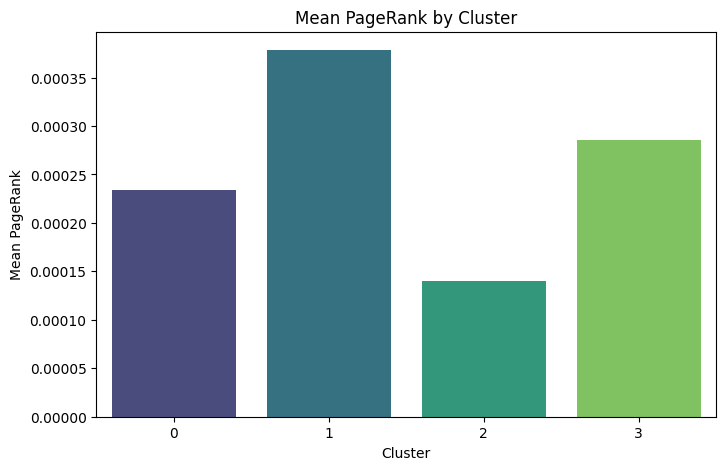

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to a DataFrame for easier plotting
plot_df = cluster_influence.reset_index()
plot_df.columns = ['cluster', 'mean_pagerank']

plt.figure(figsize=(8, 5))
sns.barplot(x='cluster', y='mean_pagerank', data=plot_df, palette='viridis')

plt.title("Mean PageRank by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Mean PageRank")
plt.show()


In [ ]:
import networkx as nx

# Load the graph you created earlier
g = nx.read_graphml("reddit_mentalhealth_combined.graphml")

# Ensure all users in your DataFrame are in the graph
for idx, row in final_df.iterrows():
    user = row['user']
    if user in g.nodes:
        g.nodes[user]['cluster'] = int(row['cluster'])
        g.nodes[user]['pagerank'] = float(row['pagerank'])

nx.write_graphml(g, "reddit_mentalhealth_clusters.graphml")
print("Graph saved with clusters and PageRank for Gephi visualization.")


Graph saved with clusters and PageRank for Gephi visualization.


**Visualizations to support the analysis**

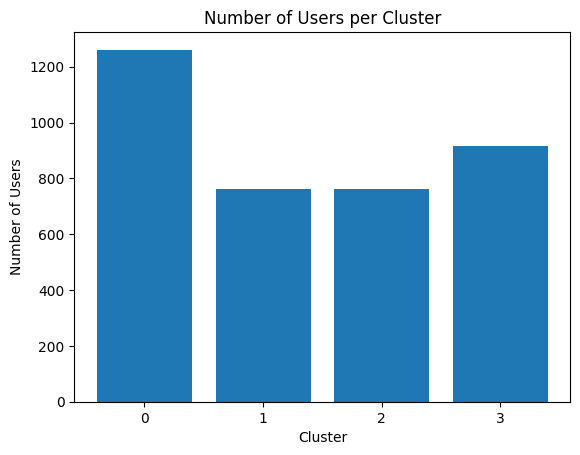

In [ ]:
cluster_sizes = final_df["cluster"].value_counts().sort_index()

plt.figure()
plt.bar(cluster_sizes.index.astype(str), cluster_sizes.values)
plt.xlabel("Cluster")
plt.ylabel("Number of Users")
plt.title("Number of Users per Cluster")
plt.show()


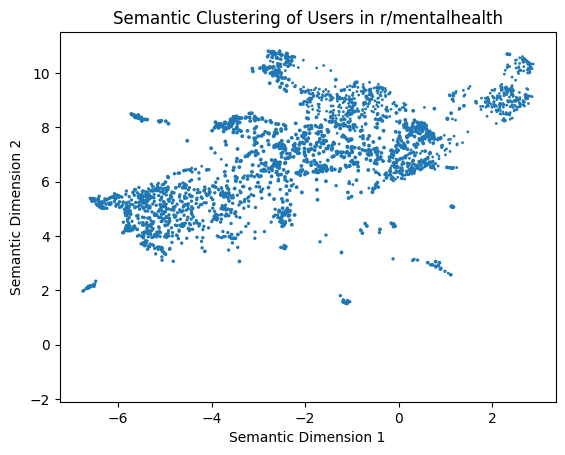

In [ ]:

plt.figure()
plt.scatter(
user_text["x"],
user_text["y"],
user_text["cluster"]
)
plt.xlabel("Semantic Dimension 1")
plt.ylabel("Semantic Dimension 2")
plt.title("Semantic Clustering of Users in r/mentalhealth")
plt.show()

**Model Justification for KMeans**

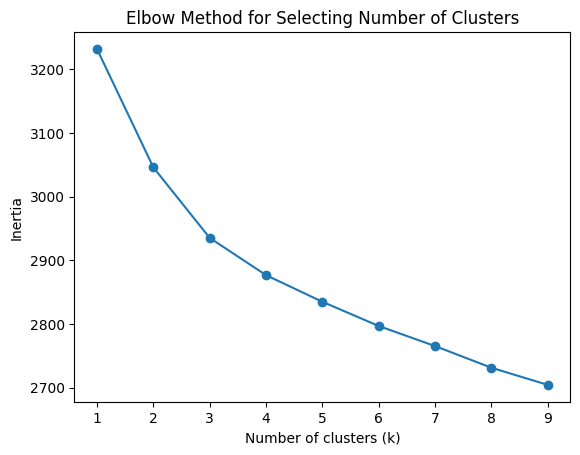

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate inertia for a range of k values
k_range = range(1, 10)
inertias = []

for k in k_range:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_model.fit(embeddings)
    inertias.append(kmeans_model.inertia_)

plt.figure()
plt.plot(list(k_range), inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Selecting Number of Clusters")
plt.show()

In [6]:
import json

def remove_all_widget_metadata(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        nb = json.load(f)

    # Remove top-level
    if "widgets" in nb.get("metadata", {}):
        del nb["metadata"]["widgets"]

    # Remove cell-level widget metadata
    for cell in nb.get("cells", []):
        if "widgets" in cell.get("metadata", {}):
            del cell["metadata"]["widgets"]

    with open(filepath, "w", encoding="utf-8") as f:
        json.dump(nb, f, indent=2)

# Run the cleaning
remove_all_widget_metadata("INST414_Final_Project (2).ipynb")
print("Cleaned notebook metadata.")


Cleaned notebook metadata.
